In [1]:
import re
import time
import pandas as pd
import json
import requests
import numpy as np
import seaborn as sns
import statsmodels.api as sm
from bs4 import BeautifulSoup
from tqdm import tqdm
from datetime import datetime

# 1.데이터 수집 

In [2]:
#당일 시가 정보 불러오기
def find_gap(stock_code):
        time.sleep(0.05)
        URL = 'https://openapi.koreainvestment.com:9443/uapi/domestic-stock/v1/quotations/inquire-time-itemchartprice'

        headers = {"Content-Type":"application/json; charset=utf-8", 
                "authorization": f"Bearer {ACCESS_TOKEN}",
                "appKey":APP_KEY,
                "appSecret":APP_SECRET,
                "tr_id":"FHPST01060000"
                }

        params =  {
                "fid_cond_mrkt_div_code": "J",
                "fid_input_hour_1": "090030",
                "fid_input_iscd": stock_code
        }

        res = requests.get(URL, headers=headers, params=params)
        return res


#한국투자 API 보안 인증키 발급 
APP_KEY = "PSDbkNNrIX3j60cW2MEFnBGZDZ1BzpgDxvC0"
APP_SECRET = "QfaZRX24K15ojO4yjG5o5dM+SUvJT4PYiK+tKKzgikyhmfrnTXoxOwn9rCf2hzXdtOhh4v3/O4bSFfQgS+u6ojdb6KgWuyub4GRraoWYaJTJyHSRqWUPab2GiCvrI/aIjx5S925MohrETq0k/eopFHgMInG0lmZdAh5TaegaZ1NDpNvPW8Y="
URL_BASE = "https://openapi.koreainvestment.com:9443"
PATH = "oauth2/tokenP"
URL = f"{URL_BASE}/{PATH}"

headers = {"content-type":"application/json"}
body = {"grant_type":"client_credentials",
        "appkey":APP_KEY, 
        "appsecret":APP_SECRET}

res = requests.post(URL, headers=headers, data=json.dumps(body))
ACCESS_TOKEN = res.json()["access_token"]

#주가 기본정보 불러오기
Kospi_df = pd.read_csv('data/kospi_code.csv')
Kosdaq_df = pd.read_csv('data/kosdaq_code.csv')
#코스피 분류
kospi = Kospi_df.filter(items= ['단축코드','한글명'])
kospi['class'] = 'kospi'
#코스닥 분류
kosdaq = Kosdaq_df.filter(items= ['단축코드','한글종목명'])
kosdaq['class'] = 'kospi'
#주가 종목코드 불러오기
kospi = kospi.rename(columns={'단축코드':'stock_code','한글명' : 'stock_name'})
kosdaq = kosdaq.rename(columns={'단축코드':'stock_code','한글종목명' : 'stock_name'})
kospi_kosdaq = pd.concat([kospi,kosdaq])
kospi_kosdaq = kospi_kosdaq.reset_index(drop=True)

In [207]:
#개장 직후 종목 검색
data = pd.DataFrame()
for i in range(len(kospi_kosdaq)):
    stock_code = kospi_kosdaq.stock_code[i]
    stock_name = kospi_kosdaq.stock_name[i]
    stock_class = kospi_kosdaq['class'][i]
    res = find_gap(stock_code)
    try : 
        gap_per = res.json().get('output2')[-1].get('prdy_ctrt')
        gap_hour = res.json().get('output2')[-1].get('stck_cntg_hour')
        temp = pd.DataFrame({
                        'stock_code': stock_code,
                        'stock_name': stock_name,
                        'stock_class' : stock_class,
                        'gap_per': gap_per,
                        'gap_hour': gap_hour,
                        }, index=[0])
        data = pd.concat([data,temp],axis=0)
    except :
        pass

data = data.reset_index(drop=True)
data['gap_int'] = data.gap_per.apply(lambda x: float(x))
stock2 = data.query('gap_int >= 2.0').reset_index(drop=True)


In [208]:
stock2

,stock_code,stock_name,gap_per,gap_hour,gap_int
0,000545,흥국화재우,2.60,090013,2.60
1,001390,KG케미칼,3.15,090029,3.15
2,006220,제주은행,7.26,090030,7.26
3,006570,대림통상,3.09,090029,3.09
4,017040,광명전기,3.85,090025,3.85
...,...,...,...,...,...
103,318000,KBG,4.04,090030,4.04
104,348340,뉴로메카,2.60,090025,2.60
105,368970,오에스피,3.42,090022,3.42
106,388720,유일로보틱스,8.35,090030,8.35


# 2. 데이터 거래정보 불러오기

In [209]:
#주식시세
def get_daily_info(stock_code):
    #api호출
    time.sleep(0.05)
    URL = 'https://openapi.koreainvestment.com:9443/uapi/domestic-stock/v1/quotations/inquire-daily-itemchartprice'

    headers = {"Content-Type":"application/json", 
            "authorization": f"Bearer {ACCESS_TOKEN}",
            "appKey":APP_KEY,
            "appSecret":APP_SECRET,
            "tr_id":"FHKST01010400"
            }

    params = {
        "FID_COND_MRKT_DIV_CODE":"J",
        "FID_INPUT_ISCD":f'{stock_code}',
        "fid_org_adj_prc": "0",
        "fid_period_div_code": "D"
    }
    #거래량, 저가 호출
    res = requests.get(URL, headers=headers, params=params)   
    res = res.json()
    res = res.get('output')[0:11]
    res.reverse()

    temp = pd.DataFrame(res).T
    temp.columns = [f'D_{i}' for i in range(10,-1,-1)]

    #당일 시가 및 고가
    daily_table = pd.DataFrame({
              'stck_oprc' :  temp['D_0']['stck_oprc'],
              'stck_hgpr'  : temp['D_0']['stck_hgpr'],
              },index=[0])
    
    #전일 저가,거래량(1일)
    b = ['stck_lwpr','acml_vol']
    for div in b:
        a = np.where(temp.index == f'{div}')[0][0]
        bin_table = temp.iloc[a:a+1,:].reset_index(drop=True)
        bin_table.columns = f'{div}_' + bin_table.columns
        daily_table = pd.concat([daily_table,bin_table],axis=1)

    return daily_table

#날짜호출
def get_date_info(stock_code):
        #api호출
    time.sleep(0.05)
    URL = 'https://openapi.koreainvestment.com:9443/uapi/domestic-stock/v1/quotations/inquire-daily-itemchartprice'

    headers = {"Content-Type":"application/json", 
            "authorization": f"Bearer {ACCESS_TOKEN}",
            "appKey":APP_KEY,
            "appSecret":APP_SECRET,
            "tr_id":"FHKST01010400"
            }

    params = {
        "FID_COND_MRKT_DIV_CODE":"J",
        "FID_INPUT_ISCD":f'{stock_code}',
        "fid_org_adj_prc": "0",
        "fid_period_div_code": "D"
    }

    #거래량, 저가 호출
    res = requests.get(URL, headers=headers, params=params)   
    res = res.json()
    date=res.get('output')[0].get('stck_bsop_date')

    return date

In [210]:
#종목별 정보 받아오기
daily_stock = pd.DataFrame()
for i in stock2.stock_code:
    daily_table = get_daily_info(i)
    daily_stock = pd.concat([daily_stock, daily_table])

#전체 합치기
daily_stock = daily_stock.reset_index(drop=True)
stock2 = pd.concat([stock2,daily_stock],axis=1)
    

In [14]:
date = get_date_info(stock_code)

# 3.데이터 전처리

In [225]:
for cn in stock2.columns[5:]:
    stock2[f'{cn}'] = stock2[f'{cn}'].apply(lambda x : int(x))

In [214]:
#증가율
stock2['gap_change'] = stock2['gap_int']

In [227]:
ex_volume = stock2.iloc[:,18:28]

#이상치 범위 설정 
q3 = ex_volume.quantile(0.75, axis=1)
q1 = ex_volume.quantile(0.25, axis=1)

IQR = q3-q1
upper_limit = q3 + 1.5*IQR

#이상치 범위 변환
upper_limit = pd.DataFrame(upper_limit).to_numpy()
ex_volume = ex_volume.to_numpy()
ex_volume = np.where(ex_volume>upper_limit,np.nan,ex_volume)
ex_volume = pd.DataFrame(ex_volume)
stock2['mean_vlome'] = ex_volume.mean(axis=1)
stock2['today_vlome'] = stock2.acml_vol_D_0.apply(lambda x : int(x))
stock2['volume_change'] = stock2.iloc[:,28:].pct_change(axis=1)['today_vlome']

In [229]:
parameter = stock2.iloc[:,5:15]
parameter = parameter.T

for i in range(len(parameter.columns)):
    name = f'price{i}' 
    parameter = parameter.rename(columns={i:name})

parameter = parameter.reset_index().drop(columns=['index'])
parameter = parameter.reset_index()

data2=pd.DataFrame()
for i in range(0,len(stock2)):
    model = sm.OLS.from_formula(f'index ~ price{i}', parameter).fit()
    slope = model.params[f'price{i}']
    temp = pd.DataFrame({'slope': slope} ,index =[i])
    data2 = pd.concat([data2,temp])

stock2['slope'] = data2



In [236]:
stock2['day_change'] = stock2['stck_hgpr'] - stock2['stck_oprc']
stock2['deter_change'] = stock2.day_change.apply(lambda x : 1 if x > 0 else 0)

In [238]:
stock_data = stock2.iloc[:,29:]
stock_data

,gap_change,mean_vlome,today_vlome,volume_change,slope,day_change,deter_change
0,2,3.765600e+03,4008,0.064372,0.004595,0,0
1,3,1.125631e+05,3728552,32.124102,-0.000425,1250,1
2,7,1.938465e+06,2196036,0.132874,-0.002273,550,1
3,3,5.073500e+03,1334669,262.066719,-0.003861,1045,1
4,3,3.402592e+05,6365970,17.709177,-0.018137,55,1
...,...,...,...,...,...,...,...
103,4,1.004756e+05,4641141,45.191711,-0.001414,580,1
104,2,3.589203e+06,2085338,-0.418997,0.000074,1250,1
105,3,2.657874e+05,1001864,2.769418,-0.007670,50,1
106,8,4.351699e+05,1483523,2.409066,-0.000459,1300,1


# 4. 결과해석

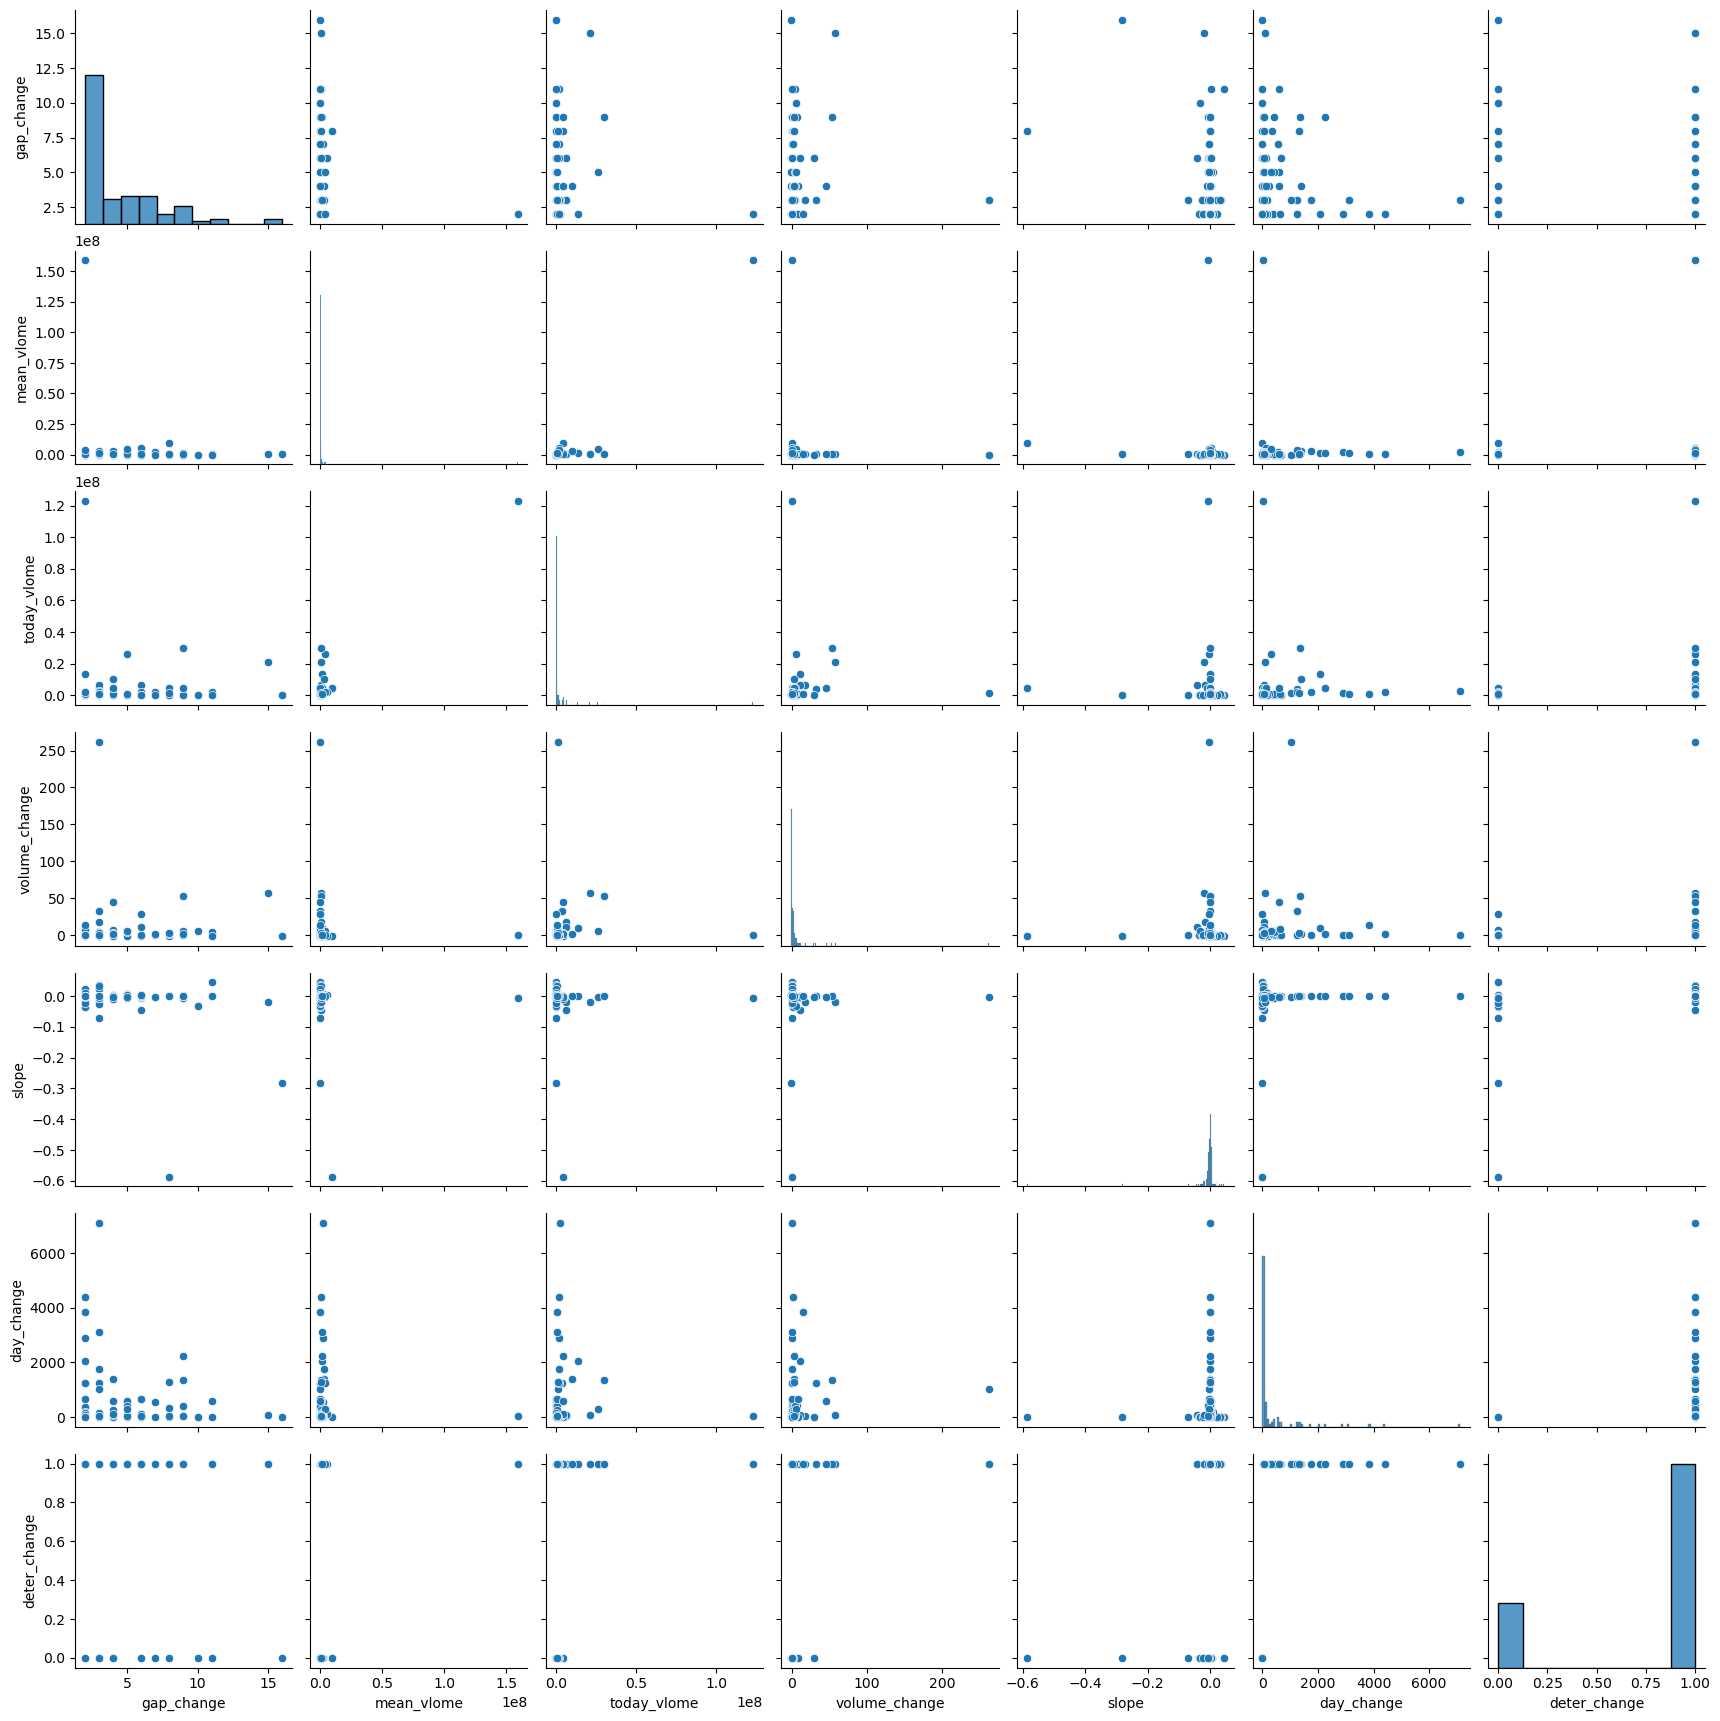

In [239]:
%matplotlib inline
sns.pairplot(stock_data)

In [242]:
Y = stock_data['deter_change']
X = stock_data[['gap_change', 'mean_vlome', 'today_vlome', 'volume_change', 'slope']]

In [243]:
X = sm.add_constant(X)
model = sm.Logit(Y,X)
results = model.fit()
print(results.summary())

Optimization terminated successfully.
         Current function value: 0.411224
         Iterations 11
                           Logit Regression Results                           
Dep. Variable:           deter_change   No. Observations:                  108
Model:                          Logit   Df Residuals:                      102
Method:                           MLE   Df Model:                            5
Date:                Wed, 08 Mar 2023   Pseudo R-squ.:                  0.2549
Time:                        18:05:58   Log-Likelihood:                -44.412
converged:                       True   LL-Null:                       -59.609
Covariance Type:            nonrobust   LLR p-value:                 1.234e-05
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.9726      0.560      1.736      0.083      -0.126       2.071
gap_change        0

In [244]:
stock2.to_csv(f'./data/{date}.csv', index=False, encoding='utf-8-sig')